## 1. Loading Text Data


In [ ]:
import pandas as pd
import os
import glob


In [161]:
# Read all files in the directory and combine then into file named corpus 

#---- df = pd.read_csv('001.txt', delimiter = "\t", names=['Text'],)

file_list = glob.glob(os.path.join(os.getcwd(), "datasets", "*.txt"))
corpus = []
for file_path in file_list:
    with open(file_path) as f_input:
        corpus.append(f_input.read())
 
#print(corpus)

# Convert the corpus list into a data frame
df = pd.DataFrame(corpus, columns= ['Text'],)

In [162]:
# random state
rs = 42

# as usual, explore the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 1 columns):
Text    200 non-null object
dtypes: object(1)
memory usage: 1.6+ KB


In [163]:
df.head(5)

,Text
0,Claxton hunting first major medal\n\nBritish h...
1,O'Sullivan could run in Worlds\n\nSonia O'Sull...
2,Greene sets sights on world title\n\nMaurice G...
3,IAAF launches fight against drugs\n\nThe IAAF ...
4,"Dibaba breaks 5,000m world record\n\nEthiopia'..."


In [164]:
# print out the first 200 characters of the first row of text column
print(df.get_value(index=2, col = 'Text')[:500])
#print(df.at[0, 'Text'] [:200])

Greene sets sights on world title

Maurice Greene aims to wipe out the pain of losing his Olympic 100m title in Athens by winning a fourth World Championship crown this summer.

He had to settle for bronze in Greece behind fellow American Justin Gatlin and Francis Obikwelu of Portugal. "It really hurts to look at that medal. It was my mistake. I lost because of the things I did," said Greene, who races in Birmingham on Friday. "It's never going to happen again. My goal - I'm going to win the wor


D:\Programs\conda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [165]:
# average length of text column
print("Average length of the data: ", df['Text'].apply(lambda x: len(x)).mean())

# Minimum length of text column
print("Minimum length of the data: ", df['Text'].apply(lambda x: len(x)).min())

# Maximum length of text column
print("Maximum length of the data: ", df['Text'].apply(lambda x: len(x)).max())

Average length of the data:  1928.895
Minimum length of the data:  648
Maximum length of the data:  9646


## 2. Data Prepocessing

In [42]:
import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

In [166]:
# initialise WordNet lemmatizer and punctuation filter
lemmatizer = WordNetLemmatizer()
punct = set(string.punctuation)

# load the provided stopwords
#df_stop = pd.read_csv('001.txt', delimiter = "\t", names=['Text'],)
#df = pd.read_csv('001.txt', delimiter = "\t", names=['Text'],)

# join provided stopwords with the default NLTK English stopwords
#stopwords = set(df_stop['Term']).union(set(sw.words('english')))
stopwords = set(sw.words('english'))

def lemmatize(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)

    return lemmatizer.lemmatize(token, tag)

In [167]:
def cab_tokenizer(document):
    # initialize token list
    tokens = []
    
    # split the document into sentences
    for sent in sent_tokenize(document):
        # split the document into tokens and then create part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # preprocess and remove unnecessary characters
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')

            # If stopword, ignore token and continue
            if token in stopwords:
                continue

            # If punctuation, ignore token and continue
            if all(char in punct for char in token):
                continue

            # Lemmatize the token and add back to the tokens list
            lemma = lemmatize(token, tag)
            tokens.append(lemma)
    
    return tokens

In [170]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tf idf vectoriser
tfidf_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
X = tfidf_vec.fit_transform(df['Text'])

# see the number of unique tokens produced by the vectorizer. Lots of them...
print(len(tfidf_vec.get_feature_names()))

36362


In [179]:
#print(tfidf_vec.get_feature_names())

## 3. Initial Document Analysis



In [172]:
from sklearn.cluster import KMeans

# K means clustering using the term vector
#kmeans = KMeans(n_clusters=7, random_state=rs).fit(X)
kmeans = KMeans(n_clusters=7, random_state=rs).fit(X)

In [173]:
# function to visualise text cluster. Useful for the assignment too :)
def visualise_text_cluster(n_clusters, cluster_centers, terms, num_word = 5):
    # -- Params --
    # cluster_centers: cluster centers of fitted/trained KMeans/other centroid-based clustering
    # terms: terms used for clustering
    # num_word: number of terms to show per cluster. Change as you please.
    
    # find features/terms closest to centroids
    ordered_centroids = cluster_centers.argsort()[:, ::-1]
    
    for cluster in range(n_clusters):
        print("Top terms for cluster {}:".format(cluster), end=" ")
        for term_idx in ordered_centroids[cluster, :5]:
            print(terms[term_idx], end=', ')
        print()
        
# call it
visualise_text_cluster(kmeans.n_clusters, kmeans.cluster_centers_, tfidf_vec.get_feature_names())

Top terms for cluster 0: indoor, world, record, olympic, bekele, 
Top terms for cluster 1: cricket, club, â £, £, â, 
Top terms for cluster 2: ball, wicket, run, strauss, australia, 
Top terms for cluster 3: england, ireland, wale, nation, rugby, 
Top terms for cluster 4: 6, open, hewitt, win, 7, 
Top terms for cluster 5: say, cup, roddick, player, play, 
Top terms for cluster 6: athletics, athens, drug, ban, athlete, 


The output above shows the terms characterising each cluster. Unfortunately, this clustering solution does not give good grouping. Too many key terms are shared between clusters (e.g. state, court, government), making it hard to differentiate clusters. This problem can be caused by unimportant terms "clouding" the feature/term vector, thus we should perform feature selection to remove them.

## 4. Feature Selection and Transformation

### 4.1. Zipf's Law and Document Frequency Filtering

Zipf's law is an empirical law based on distribution of phrases in many large collections of documents. It states that the frequency of a term will be inversely proportioned with its rank in the frequency table ([more info](https://en.wikipedia.org/wiki/Zipf%27s_law)). Zipf law can be observed when you plot document occurences vs term occurences from the vectorised terms.

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt

# creating tf-idf terms - a bit slow, do it occasionaly
def calculate_tf_idf_terms(document_col):
    # Param - document_col: collection of raw document text that you want to analyse
    from sklearn.feature_extraction.text import CountVectorizer

    # use count vectorizer to find TF and DF of each term
    count_vec = CountVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
    X_count = count_vec.fit_transform(df['Text'])
    
    # create list of terms and their tf and df
    terms = [{'term': t, 'idx': count_vec.vocabulary_[t],
              'tf': X_count[:, count_vec.vocabulary_[t]].sum(),
              'df': X_count[:, count_vec.vocabulary_[t]].count_nonzero()}
             for t in count_vec.vocabulary_]
    #print(count_vec.get_feature_names())
    #print(len(count_vec.get_feature_names()))
    return terms
    
terms = calculate_tf_idf_terms(df['Text'])

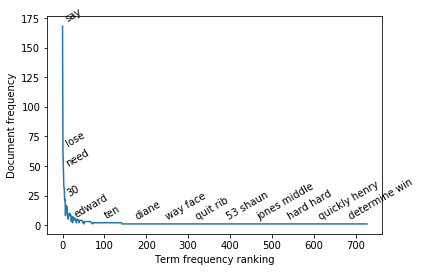

In [177]:
# visualisation of ZIPF law
def visualise_zipf(terms, itr_step = 50):
    from scipy.spatial.distance import euclidean
    from math import sqrt
    
    # --- Param ---
    # terms: collection of terms dictionary from calculate_tf_idf_terms function
    # itr_step: used to control how many terms that you want to plot. Num of terms to plot = N terms / itr_step
    
    # sort terms by its frequency
    terms.sort(key=lambda x: (x['tf'], x['df']), reverse=True)
    
    # select a few of the terms for plotting purpose
    sel_terms = [terms[i] for i in range(0, len(terms), itr_step)]
    labels = [term['term'] for term in sel_terms]
    
    # plot term frequency ranking vs its DF
    plt.plot(range(len(sel_terms)), [x['df'] for x in sel_terms])
    plt.xlabel('Term frequency ranking')
    plt.ylabel('Document frequency')
    
    max_x = len(sel_terms)
    max_y = max([x['df'] for x in sel_terms])
    
    # annotate the points
    prev_x, prev_y = 0, 0
    for label, x, y in zip(labels,range(len(sel_terms)), [x['df'] for x in sel_terms]):
        # calculate the relative distance between labels to increase visibility
        x_dist = (abs(x - prev_x) / float(max_x)) ** 2
        y_dist = (abs(y - prev_y) / float(max_y)) ** 2
        scaled_dist = sqrt(x_dist + y_dist)
        
        if (scaled_dist > 0.1):
            plt.text(x+2, y+2, label, {'ha': 'left', 'va': 'bottom'}, rotation=30)
            prev_x, prev_y = x, y
    
    plt.show()
    
visualise_zipf(terms)

In [178]:
print("The top 10 terms with high tf and df")
terms[:10]

The top 10 terms with high tf and df


[{'term': 'say', 'idx': 27447, 'tf': 447, 'df': 168},
 {'term': 'year', 'idx': 36020, 'tf': 308, 'df': 134},
 {'term': 'game', 'idx': 13304, 'tf': 249, 'df': 106},
 {'term': 'win', 'idx': 35322, 'tf': 246, 'df': 102},
 {'term': 'play', 'idx': 23829, 'tf': 240, 'df': 104},
 {'term': 'one', 'idx': 22447, 'tf': 204, 'df': 104},
 {'term': 'go', 'idx': 14040, 'tf': 203, 'df': 112},
 {'term': 'take', 'idx': 31441, 'tf': 202, 'df': 112},
 {'term': 'england', 'idx': 10579, 'tf': 199, 'df': 52},
 {'term': 'two', 'idx': 33467, 'tf': 197, 'df': 103}]

Zipf's law is applied in text mining during the feature selection process. Terms that occured on the left-top area of the diagram above (e.g. state and latter) are terms that are too frequent (high TF and DF). Meanwhile, terms on the right-bottom side of the diagram e.g. ("acquire revision" and "facilitate
inroad") only appear in select number of documents. Both groups of terms do not add value, thus filtering the low and high end terms, and keeping only terms in the middle area will benefit a clustering solution. This filtering can easily be done through limiting the DF value of terms in vectoriser.

In [185]:
# another tf idf vectoriser
# limit the terms produced to terms that occured in min of 2 documents and max 80% of all documents
filter_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2), min_df=2, max_df=0.8)
X_filter = filter_vec.fit_transform(df['Text'])

# see the number of unique tokens produced by the vectorizer. Reduced!
print(len(filter_vec.get_feature_names()))

6916


print(filter_vec.get_feature_names())

This process greatly reduced the number of terms in a feature set. Try to build another clustering solution and check if the clusters are more meaningful.

In [182]:
%%time
# K means clustering using the new term vector, time it for comparison to SVD
#kmeans_fil = KMeans(n_clusters=7, random_state=rs).fit(X_filter)
kmeans_fil = KMeans(n_clusters=7, random_state=rs).fit(X_filter)

Wall time: 6.65 s


In [183]:
# visualisation
visualise_text_cluster(kmeans_fil.n_clusters, kmeans_fil.cluster_centers_, filter_vec.get_feature_names())

Top terms for cluster 0: open, grand slam, australian, slam, australian open, 
Top terms for cluster 1: 6, roddick, 7, moya, spain, 
Top terms for cluster 2: world, race, athens, year, athletics, 
Top terms for cluster 3: sri, sri lanka, lanka, cricket, icc, 
Top terms for cluster 4: club, want, â £, â, £, 
Top terms for cluster 5: game, england, play, team, arsenal, 
Top terms for cluster 6: ball, wicket, strauss, run, england, 


With much less terms in the feature vector, the clustering process managed to
result in much more meaningful solution. The cluster topics can be distinctly
recognized like justice department (\#6), military (\#2), parliament (\#3), etc.

### 4.2. Singular Value Decomposition

Singular value decomposition (SVD) is a dimensionality reduction method that
works by factorizing a matrix. SVD is used widely in data mining through many techniques like Principal Component Analysis (PCA - a common dimensionality reduction method applied on traditional data to understand variables dependencies) and in text mining, Latent Semantic Analysis (LSA). LSA is
applied to analyzing documents by finding the underlying meaning or concepts of words in these documents. LSA uses SVD to reduce the number of terms while
preserving the similarity structure among documents.

[More info](https://en.wikipedia.org/wiki/Latent_semantic_analysis)

LSA is typically used to help comparing and finding similar documents (like in document clustering and classification) and also finding synonymous/polysemous relationships between words. LSA can help in increasing speed (less features) and accuracy (comparison is now based on document concept similary instead of word similarity) of the model.

In the following code, we will reduce the original `X` into only 100 components.

In [87]:
from sklearn.decomposition import TruncatedSVD

#svd = TruncatedSVD(n_components=100, random_state=42)
svd = TruncatedSVD(n_components=3, random_state=42)
X_trans = svd.fit_transform(X_filter)

Each of the components produced by SVD contain weights associated with each word. The larger the weight is, the more connected the word is to the component.

In [88]:
# sort the components by largest weighted word
sorted_comp = svd.components_.argsort()[:, ::-1]
terms = filter_vec.get_feature_names()

# visualise word - concept/component relationships
for comp_num in range(3):
    print("Top terms in component #{}".format(comp_num), end=" ")
    for i in sorted_comp[comp_num, :10]:
        print(terms[i], end=", ")
    print()

Top terms in component #0 medal, year, first, major medal, major, first major, european, hurdle, win, british, 
Top terms in component #1 major medal, major, first major, first, medal, win, british, confident, european, 25 year, 
Top terms in component #2 first, major medal, first major, major, old, long, new, year old, season, take, 


The transformed `X` can now be used for clustering. Build a new clustering solution on the transformed `X`.

In [89]:
%%time
# K-means clustering using LSA-transformed X
svd_kmeans = KMeans(n_clusters=3, random_state=rs).fit(X_trans)

Wall time: 9.97 ms


SVD transformed clustering is much much faster than the normal one (~50 ms vs ~800 ms). Let's see if the SVD transformation changes the clustering characteristics.

In [90]:
# transform cluster centers back to original feature space for visualisation
original_space_centroids = svd.inverse_transform(svd_kmeans.cluster_centers_)

# visualisation
visualise_text_cluster(svd_kmeans.n_clusters, original_space_centroids, filter_vec.get_feature_names())

Top terms for cluster 0: year, hurdle, 25, old, long, 
Top terms for cluster 1: medal, major medal, first major, major, win, 
Top terms for cluster 2: major medal, major, first major, first, medal, 


There is not much difference in the cluster topic terms between SVD-transformed feature vs normal feature. This means the original clustering solution has managed to capture the difference in concepts/topics in the document space. SVD is still beneficial due to reduced training time, which is extremely beneficial in large document clustering.

## End Notes

This practical gives you a tour to familiarize with text mining functions and libraries in Python, and how a data set appearing in the text format can be analyzed with data mining techniques such as clustering. You prepared the FEDPAPERS data set for finding the natural groupings of the text data. It particularly covered text pre-processing (such as stop-word removal, lemmatizing), dimensionality reduction (applying Zipf’s law and transformation of the text data with a factorization method (for feature selection) called as Singular Value Decomposition (SVD)), and finally performing clustering on the text data for finding similarity and understanding the common themes in the data set.